# Checking the preprocessed data
In this notebook, we'll analyze the preprocessed datasets to check their quality.

# Imports and paths

In [1]:
%cd ..

/home/cdauvill/inria/multi_sources


In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from netCDF4 import Dataset
from pathlib import Path

The preprocessed datasets are stored in ```data/sources/source_name/source_group/source_subgroup/``` etc. There can be any number of subgroups. The final repertory should contain four files:
* ```dataset.nc```: the dataset itself in netCDF4 format, which can be lazy-loaded with ```xarray.open_mfdataset```.
* ```normalization_mean.nc```: a much smaller dataset containing the normalization mean for the dataset's variables.
* ```normalization_std.nc```: same, for the standard deviation.

In [3]:
sources_dir = Path("data/sources/")
tc_primed_dir = sources_dir / "tc_primed"

# Microwave images
The MW images are stored under ```data/sources/<SENSOR_SATELLITE>/<SWATHNUMBER>/```, where ```<SWATHNUMBER>``` can be ```S1``` up to ```S6``` depending on the sensor / satellite pair.

In [4]:
mw_files = list((tc_primed_dir / "microwave" / "AMSR2_GCOMW1" / "S5" / "2017" / "AL").glob('*.nc'))
dataset = xr.open_mfdataset(mw_files, combine="nested", concat_dim="sample")
# Load the coordinates in memory, while leaving the variables lazy
dataset.assign_coords({coord: dataset[coord].load() for coord in dataset.coords})
dataset

<xarray.Dataset> Size: 730MB
Dimensions:            (sample: 199, scan: 236, pixel: 486)
Coordinates:
    basin              (sample) <U2 2kB 'AL' 'AL' 'AL' 'AL' ... 'AL' 'AL' 'AL'
    cyclone_number     (sample) int8 199B 16 16 16 16 16 16 ... 6 19 19 19 19 19
    season             (sample) int16 398B 2017 2017 2017 ... 2017 2017 2017
    time               (sample) datetime64[ns] 2kB 2017-10-03T18:55:03 ... 20...
Dimensions without coordinates: sample, scan, pixel
Data variables:
    latitude           (sample, scan, pixel) float32 91MB dask.array<chunksize=(12, 236, 486), meta=np.ndarray>
    longitude          (sample, scan, pixel) float32 91MB dask.array<chunksize=(12, 236, 486), meta=np.ndarray>
    x                  (sample, scan, pixel) float64 183MB dask.array<chunksize=(12, 236, 486), meta=np.ndarray>
    y                  (sample, scan, pixel) float64 183MB dask.array<chunksize=(12, 236, 486), meta=np.ndarray>
    TB_A89.0V          (sample, scan, pixel) float32 91MB dask.array<chunksize=(12, 236, 486), meta=np.ndarray>
    TB_A89.0H          (sample, scan, pixel) float32 91MB dask.array<chunksize=(12, 236, 486), meta=np.ndarray>
    instrument_name    (sample) <U5 4kB dask.array<chunksize=(12,), meta=np.ndarray>
    platform_name      (sample) <U6 5kB dask.array<chunksize=(12,), meta=np.ndarray>
    coverage_fraction  (sample) float32 796B dask.array<chunksize=(12,), meta=np.ndarray>
    ERA5_time          (sample) datetime64[ns] 2kB dask.array<chunksize=(12,), meta=np.ndarray>

Let's first print some info on the basin and cyclone numbers:

In [5]:
print("Unique basins: ", np.unique(dataset.basin.data))
print("Storm numbers: ", np.unique(dataset.cyclone_number.data))

Unique basins:  ['AL']
Storm numbers:  [ 1  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


Let's select some examples from one of the storms:

In [6]:
a_storm = dataset.where(dataset.cyclone_number==dataset.cyclone_number.data[100], drop=True).sortby('time')
a_storm

<xarray.Dataset> Size: 114MB
Dimensions:            (sample: 31, scan: 236, pixel: 486)
Coordinates:
    basin              (sample) <U2 248B 'AL' 'AL' 'AL' 'AL' ... 'AL' 'AL' 'AL'
    cyclone_number     (sample) int8 31B 12 12 12 12 12 12 ... 12 12 12 12 12 12
    season             (sample) int16 62B 2017 2017 2017 2017 ... 2017 2017 2017
    time               (sample) datetime64[ns] 248B 2017-09-04T03:42:04 ... 2...
Dimensions without coordinates: sample, scan, pixel
Data variables:
    latitude           (sample, scan, pixel) float32 14MB dask.array<chunksize=(31, 236, 486), meta=np.ndarray>
    longitude          (sample, scan, pixel) float32 14MB dask.array<chunksize=(31, 236, 486), meta=np.ndarray>
    x                  (sample, scan, pixel) float64 28MB dask.array<chunksize=(31, 236, 486), meta=np.ndarray>
    y                  (sample, scan, pixel) float64 28MB dask.array<chunksize=(31, 236, 486), meta=np.ndarray>
    TB_A89.0V          (sample, scan, pixel) float32 14MB dask.array<chunksize=(31, 236, 486), meta=np.ndarray>
    TB_A89.0H          (sample, scan, pixel) float32 14MB dask.array<chunksize=(31, 236, 486), meta=np.ndarray>
    instrument_name    (sample) object 248B dask.array<chunksize=(31,), meta=np.ndarray>
    platform_name      (sample) object 248B dask.array<chunksize=(31,), meta=np.ndarray>
    coverage_fraction  (sample) float32 124B dask.array<chunksize=(31,), meta=np.ndarray>
    ERA5_time          (sample) datetime64[ns] 248B dask.array<chunksize=(31,), meta=np.ndarray>

We now get much fewer samples. Let's plot the different time steps of that particular storm. The microwave images are the 2D variables that are not ```latitude, longitude, x, ``` or ```y```:

In [7]:
mw_vars = [var_name for var_name, arr in a_storm.variables.items() if len(arr.dims) >= 3]
mw_vars = [var for var in mw_vars if var not in ['latitude', 'longitude', 'x', 'y']]
print("Found variables ", mw_vars)

Found variables  ['TB_A89.0V', 'TB_A89.0H']


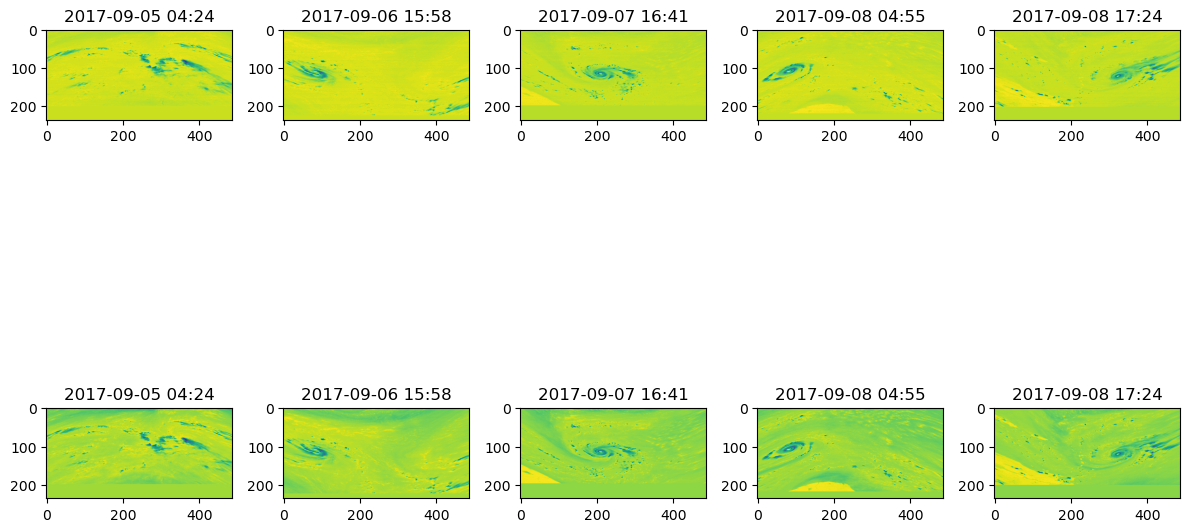

In [8]:
fig, axes = plt.subplots(nrows=len(mw_vars), ncols=5, squeeze=False, figsize=(12, 10))
for i in range(len(mw_vars)):
    for j in range(5):
        axes[i, j].imshow(a_storm.isel(sample=j+2)[mw_vars[i]])
        axes[i, j].set_title(pd.to_datetime(a_storm.isel(sample=j+2).time.data).strftime("%Y-%m-%d %H:%M"))
plt.tight_layout()

Let's plot the distance to the storm's center:

In [25]:
center_dist = (a_storm['x'] ** 2 + a_storm['y'] ** 2) ** 0.5

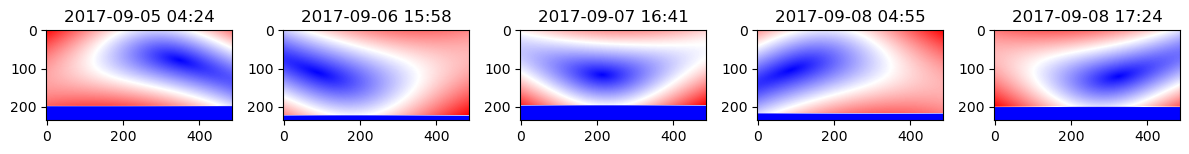

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=5, squeeze=False, figsize=(12, 10))
for j in range(5):
    axes[0, j].imshow(center_dist.isel(sample=j+2), cmap="bwr")
    axes[0, j].set_title(pd.to_datetime(a_storm.isel(sample=j+2).time.data).strftime("%Y-%m-%d %H:%M"))
plt.tight_layout()

Let's plot the ```latitude``` and ```longitude variables```: 

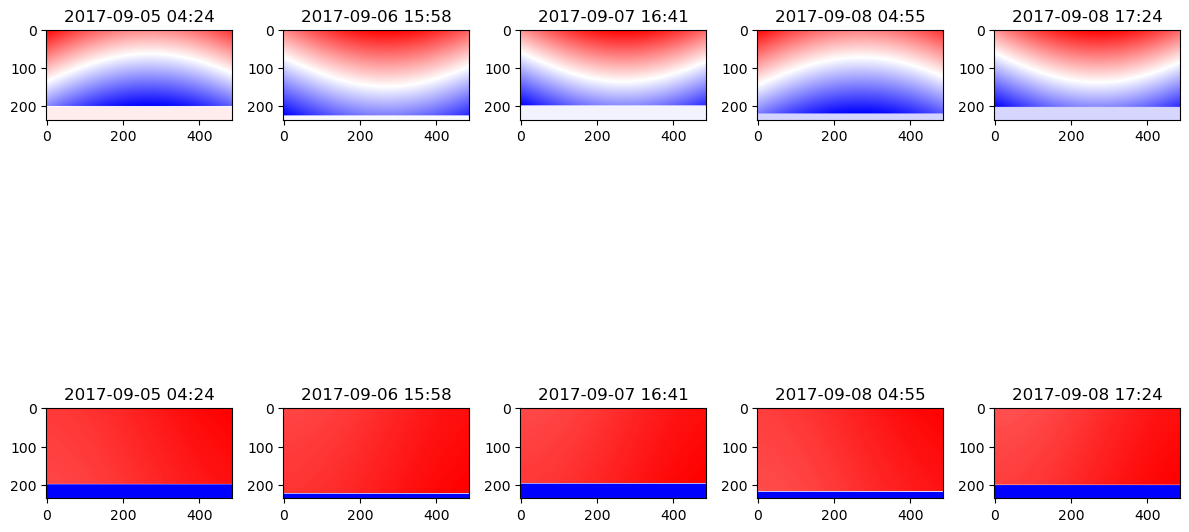

In [10]:
fig, axes = plt.subplots(nrows=len(mw_vars), ncols=5, squeeze=False, figsize=(12, 10))
for i, var in enumerate(['latitude', 'longitude']):
    for j in range(5):
        axes[i, j].imshow(a_storm.isel(sample=j+2)[var], cmap="bwr")
        axes[i, j].set_title(pd.to_datetime(a_storm.isel(sample=j+2).time.data).strftime("%Y-%m-%d %H:%M"))
plt.tight_layout()

Since we're only looking at one basin, the longitude barely varies (not even enough for matlplotlib to map it into several colors).